<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: MIRI LRS Slit

## Spec2: Assign_wcs()
<span style="color:red"> **Instruments Affected**</span>: FGS, MIRI, NIRCam, NIRISS, NIRSpec 

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Get Documentaion String for Markdown Blocks](#markdown_from_docs) <br> [Loading Data](#data_ID) <br> [Run JWST Pipeline](#pipeline_ID) <br> [Create Figure or Print Output](#residual_ID) <br> [About This Notebook](#about_ID) <br>

</div>

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
import shutil
data_dir = TemporaryDirectory()

# If you have files that are in the notebook's directory, but that the notebook will need to use while
# running, copy them into the temporary directory here.
#
# files = ['name_of_file']
# for file_name in files:
#     shutil.copy(file_name, os.path.join(data_dir.name, file_name))

os.chdir(data_dir.name)

<a id="imports_ID"></a>
# Imports
List the library imports and why they are relevant to this notebook.

* os, glob for general  OS operations
* numpy
* logging
* astropy.io for opening fits files
* astropy.utils for remote data retrieval
* inspect to get the docstring of our objects.
* IPython.display for printing markdown output
* jwst.datamodels for building model for JWST Pipeline
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot to generate plot
* matplotlib.patches to plot a shape
* pysiaf for SIAF access
* miricoord for coordinate conversion tools
* gwcs for wcs tools

[Top of Page](#title_ID)

In [2]:
import inspect
import numpy as np
import glob
import os
import logging
from IPython.display import Markdown
from jwst.datamodels import RampModel, ImageModel, CubeModel
from jwst.pipeline import Detector1Pipeline, Spec2Pipeline
from jwst.assign_wcs import AssignWcsStep
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import astropy.io.fits as fits
import astropy.io.ascii as ascii
from astropy.table import Table, Column
from astropy.utils.data import download_file
from gwcs.wcstools import grid_from_bounding_box
from numpy.testing import assert_allclose

from pysiaf import Siaf
import miricoord.imager.mirim_tools as mt
import miricoord.lrs.toolversions.lrs_pipetools_cdp7 as tv
from miricoord.lrs.lrs_pipetools import xytov2v3lam

from ci_watson.artifactory_helpers import get_bigdata

%matplotlib inline


<a id="intro_ID"></a>
# Introduction


In this notebook we will test the assign_wcs step of Spec2Pipeline() for **LRS slit** observations.

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/assign_wcs/index.html#assign-wcs-step

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/assign_wcs


### Calibration WG Requested Algorithm: 

https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Spectral+GWCS+Information



[Top of Page](#title_ID)

<a id="data_ID"></a>
# Loading Data

We are using here a simulated LRS slit observation, generated with MIRISim v2.3.0 (as of Dec 2020). It is a simple along-slit-nodded observation of a point source (the input was modelled on the flux calibrator BD+60). LRS slit observations cover the full array. 


[Top of Page](#title_ID)

In [3]:
Slitfile1 = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_spec2',
                                    'spec2_miri_test',
                                    'miri_lrs_slit_pt_nod1_v2.3.fits')
 
Slitfile2 = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_spec2',
                                    'spec2_miri_test',
                                    'miri_lrs_slit_pt_nod2_v2.3.fits')

files = [Slitfile1, Slitfile2]

In [4]:
print(files)

['/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc/miri_lrs_slit_pt_nod1_v2.3.fits', '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc/miri_lrs_slit_pt_nod2_v2.3.fits']


<a id="pipeline_ID"></a>
# Run JWST Pipeline

First we run the data through the Detector1() pipeline to convert the raw counts into slopes. This should use the calwebb_detector1.cfg file. The output of this stage will then be run through the assign_wcs() step, which is part of the Spec2Pipeline. 

[Top of Page](#title_ID)

### CalDetector1

We first run the data through the Detector1 pipeline, ensuring to pass the calwebb_detector1.cfg configuration file. 

In [5]:
det1_out = []
nods = []
for ff in files:
    det1 = Detector1Pipeline.call(ff, save_results=True)
    if 'nod1' in ff:
        nodno = 'nod1'
    else:
        nodno = 'nod2'
    det1_out.append(det1)
    nods.append(nodno)

2021-02-18 11:23:35,306 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_system_datalvl_0002.rmap       694 bytes  (1 / 141 files) (0 / 390.2 K bytes)


2021-02-18 11:23:35,341 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_system_calver_0024.rmap      2.8 K bytes  (2 / 141 files) (694 / 390.2 K bytes)


2021-02-18 11:23:35,375 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_system_0023.imap               385 bytes  (3 / 141 files) (3.4 K / 390.2 K bytes)


2021-02-18 11:23:35,401 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_wavelengthrange_0017.rmap    1.1 K bytes  (4 / 141 files) (3.8 K / 390.2 K bytes)


2021-02-18 11:23:35,428 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_wavecorr_0003.rmap      833 bytes  (5 / 141 files) (4.9 K / 390.2 K bytes)


2021-02-18 11:23:35,459 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_superbias_0039.rmap   15.9 K bytes  (6 / 141 files) (5.8 K / 390.2 K bytes)


2021-02-18 11:23:35,490 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_sflat_0011.rmap     19.3 K bytes  (7 / 141 files) (21.7 K / 390.2 K bytes)


2021-02-18 11:23:35,521 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_saturation_0017.rmap    2.0 K bytes  (8 / 141 files) (40.9 K / 390.2 K bytes)


2021-02-18 11:23:35,554 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_refpix_0014.rmap     1.5 K bytes  (9 / 141 files) (42.9 K / 390.2 K bytes)


2021-02-18 11:23:35,585 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_readnoise_0020.rmap    2.3 K bytes  (10 / 141 files) (44.5 K / 390.2 K bytes)


2021-02-18 11:23:35,617 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_photom_0012.rmap       907 bytes  (11 / 141 files) (46.8 K / 390.2 K bytes)


2021-02-18 11:23:35,650 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_pathloss_0003.rmap      932 bytes  (12 / 141 files) (47.7 K / 390.2 K bytes)


2021-02-18 11:23:35,679 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_pars-spec2pipeline_0004.rmap    1.8 K bytes  (13 / 141 files) (48.6 K / 390.2 K bytes)


2021-02-18 11:23:35,709 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_ote_0020.rmap        1.0 K bytes  (14 / 141 files) (50.5 K / 390.2 K bytes)


2021-02-18 11:23:35,733 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_msaoper_0003.rmap      783 bytes  (15 / 141 files) (51.5 K / 390.2 K bytes)


2021-02-18 11:23:35,761 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_msa_0018.rmap        1.0 K bytes  (16 / 141 files) (52.3 K / 390.2 K bytes)


2021-02-18 11:23:35,794 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_mask_0021.rmap       1.5 K bytes  (17 / 141 files) (53.3 K / 390.2 K bytes)


2021-02-18 11:23:35,824 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_linearity_0017.rmap    1.6 K bytes  (18 / 141 files) (54.7 K / 390.2 K bytes)


2021-02-18 11:23:35,854 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_ipc_0006.rmap          876 bytes  (19 / 141 files) (56.3 K / 390.2 K bytes)


2021-02-18 11:23:35,884 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_ifuslicer_0008.rmap    1.0 K bytes  (20 / 141 files) (57.2 K / 390.2 K bytes)


2021-02-18 11:23:35,915 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_ifupost_0010.rmap      991 bytes  (21 / 141 files) (58.2 K / 390.2 K bytes)


2021-02-18 11:23:35,946 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_ifufore_0008.rmap      991 bytes  (22 / 141 files) (59.2 K / 390.2 K bytes)


2021-02-18 11:23:35,978 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_gain_0019.rmap       1.8 K bytes  (23 / 141 files) (60.2 K / 390.2 K bytes)


2021-02-18 11:23:36,010 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_fpa_0019.rmap        1.0 K bytes  (24 / 141 files) (61.9 K / 390.2 K bytes)


2021-02-18 11:23:36,042 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_fore_0017.rmap       3.4 K bytes  (25 / 141 files) (63.0 K / 390.2 K bytes)


2021-02-18 11:23:36,072 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_flat_0014.rmap       3.8 K bytes  (26 / 141 files) (66.4 K / 390.2 K bytes)


2021-02-18 11:23:36,104 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_fflat_0009.rmap      3.3 K bytes  (27 / 141 files) (70.2 K / 390.2 K bytes)


2021-02-18 11:23:36,138 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_extract1d_0012.rmap    1.2 K bytes  (28 / 141 files) (73.5 K / 390.2 K bytes)


2021-02-18 11:23:36,172 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_disperser_0019.rmap    3.9 K bytes  (29 / 141 files) (74.7 K / 390.2 K bytes)


2021-02-18 11:23:36,204 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_dflat_0006.rmap      1.1 K bytes  (30 / 141 files) (78.7 K / 390.2 K bytes)


2021-02-18 11:23:36,235 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_dark_0032.rmap      14.5 K bytes  (31 / 141 files) (79.7 K / 390.2 K bytes)


2021-02-18 11:23:36,261 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_cubepar_0007.rmap      915 bytes  (32 / 141 files) (94.3 K / 390.2 K bytes)


2021-02-18 11:23:36,285 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_collimator_0017.rmap    1.1 K bytes  (33 / 141 files) (95.2 K / 390.2 K bytes)


2021-02-18 11:23:36,307 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_camera_0017.rmap     1.0 K bytes  (34 / 141 files) (96.2 K / 390.2 K bytes)


2021-02-18 11:23:36,339 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_barshadow_0003.rmap      877 bytes  (35 / 141 files) (97.3 K / 390.2 K bytes)


2021-02-18 11:23:36,367 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_area_0014.rmap       4.5 K bytes  (36 / 141 files) (98.1 K / 390.2 K bytes)


2021-02-18 11:23:36,396 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_apcorr_0005.rmap     5.3 K bytes  (37 / 141 files) (102.6 K / 390.2 K bytes)


2021-02-18 11:23:36,431 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_0217.imap            4.8 K bytes  (38 / 141 files) (107.9 K / 390.2 K bytes)


2021-02-18 11:23:36,463 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_wfssbkg_0002.rmap     2.3 K bytes  (39 / 141 files) (112.7 K / 390.2 K bytes)


2021-02-18 11:23:36,495 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_wavelengthrange_0005.rmap      811 bytes  (40 / 141 files) (115.0 K / 390.2 K bytes)


2021-02-18 11:23:36,527 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_trappars_0004.rmap      753 bytes  (41 / 141 files) (115.8 K / 390.2 K bytes)


2021-02-18 11:23:36,557 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_trapdensity_0004.rmap      774 bytes  (42 / 141 files) (116.5 K / 390.2 K bytes)


2021-02-18 11:23:36,588 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_throughput_0004.rmap      979 bytes  (43 / 141 files) (117.3 K / 390.2 K bytes)


2021-02-18 11:23:36,620 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_superbias_0022.rmap    4.6 K bytes  (44 / 141 files) (118.3 K / 390.2 K bytes)


2021-02-18 11:23:36,652 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_specwcs_0005.rmap     2.3 K bytes  (45 / 141 files) (122.9 K / 390.2 K bytes)


2021-02-18 11:23:36,683 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_saturation_0011.rmap      693 bytes  (46 / 141 files) (125.2 K / 390.2 K bytes)


2021-02-18 11:23:36,713 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_readnoise_0008.rmap      969 bytes  (47 / 141 files) (125.9 K / 390.2 K bytes)


2021-02-18 11:23:36,741 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_photom_0026.rmap        996 bytes  (48 / 141 files) (126.8 K / 390.2 K bytes)


2021-02-18 11:23:36,772 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_persat_0005.rmap        738 bytes  (49 / 141 files) (127.8 K / 390.2 K bytes)


2021-02-18 11:23:36,801 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_pathloss_0002.rmap      707 bytes  (50 / 141 files) (128.6 K / 390.2 K bytes)


2021-02-18 11:23:36,831 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_pars-tweakregstep_0003.rmap    2.2 K bytes  (51 / 141 files) (129.3 K / 390.2 K bytes)


2021-02-18 11:23:36,860 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_pars-image2pipeline_0002.rmap      712 bytes  (52 / 141 files) (131.5 K / 390.2 K bytes)


2021-02-18 11:23:36,890 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_mask_0017.rmap          735 bytes  (53 / 141 files) (132.2 K / 390.2 K bytes)


2021-02-18 11:23:36,921 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_linearity_0016.rmap      827 bytes  (54 / 141 files) (133.0 K / 390.2 K bytes)


2021-02-18 11:23:36,952 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_ipc_0006.rmap           590 bytes  (55 / 141 files) (133.8 K / 390.2 K bytes)


2021-02-18 11:23:36,981 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_gain_0010.rmap          838 bytes  (56 / 141 files) (134.4 K / 390.2 K bytes)


2021-02-18 11:23:37,011 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_flat_0019.rmap        4.1 K bytes  (57 / 141 files) (135.2 K / 390.2 K bytes)


2021-02-18 11:23:37,039 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_extract1d_0006.rmap      854 bytes  (58 / 141 files) (139.4 K / 390.2 K bytes)


2021-02-18 11:23:37,071 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_drizpars_0004.rmap      519 bytes  (59 / 141 files) (140.2 K / 390.2 K bytes)


2021-02-18 11:23:37,102 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_distortion_0017.rmap      899 bytes  (60 / 141 files) (140.7 K / 390.2 K bytes)


2021-02-18 11:23:37,130 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_dark_0027.rmap        4.0 K bytes  (61 / 141 files) (141.6 K / 390.2 K bytes)


2021-02-18 11:23:37,154 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_area_0012.rmap        1.1 K bytes  (62 / 141 files) (145.6 K / 390.2 K bytes)


2021-02-18 11:23:37,183 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_apcorr_0004.rmap      4.1 K bytes  (63 / 141 files) (146.7 K / 390.2 K bytes)


2021-02-18 11:23:37,209 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_abvegaoffset_0002.rmap    1.3 K bytes  (64 / 141 files) (150.8 K / 390.2 K bytes)


2021-02-18 11:23:37,236 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_0139.imap             4.6 K bytes  (65 / 141 files) (152.1 K / 390.2 K bytes)


2021-02-18 11:23:37,266 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_wfssbkg_0003.rmap     7.2 K bytes  (66 / 141 files) (156.7 K / 390.2 K bytes)


2021-02-18 11:23:37,296 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_wavelengthrange_0009.rmap      945 bytes  (67 / 141 files) (163.9 K / 390.2 K bytes)


2021-02-18 11:23:37,324 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_tsophot_0002.rmap       794 bytes  (68 / 141 files) (164.8 K / 390.2 K bytes)


2021-02-18 11:23:37,355 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_trappars_0003.rmap    1.6 K bytes  (69 / 141 files) (165.6 K / 390.2 K bytes)


2021-02-18 11:23:37,385 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_trapdensity_0003.rmap    1.6 K bytes  (70 / 141 files) (167.2 K / 390.2 K bytes)


2021-02-18 11:23:37,417 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_superbias_0006.rmap    2.6 K bytes  (71 / 141 files) (168.8 K / 390.2 K bytes)


2021-02-18 11:23:37,446 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_specwcs_0008.rmap     1.7 K bytes  (72 / 141 files) (171.4 K / 390.2 K bytes)


2021-02-18 11:23:37,476 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_saturation_0006.rmap    2.2 K bytes  (73 / 141 files) (173.1 K / 390.2 K bytes)


2021-02-18 11:23:37,505 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_readnoise_0006.rmap    5.6 K bytes  (74 / 141 files) (175.2 K / 390.2 K bytes)


2021-02-18 11:23:37,536 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_psfmask_0005.rmap    10.7 K bytes  (75 / 141 files) (180.8 K / 390.2 K bytes)


2021-02-18 11:23:37,570 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_photom_0010.rmap      4.3 K bytes  (76 / 141 files) (191.6 K / 390.2 K bytes)


2021-02-18 11:23:37,598 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_persat_0004.rmap      1.6 K bytes  (77 / 141 files) (195.9 K / 390.2 K bytes)


2021-02-18 11:23:37,629 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_pars-tweakregstep_0002.rmap    4.5 K bytes  (78 / 141 files) (197.5 K / 390.2 K bytes)


2021-02-18 11:23:37,657 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_mask_0007.rmap        2.3 K bytes  (79 / 141 files) (201.9 K / 390.2 K bytes)


2021-02-18 11:23:37,685 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_linearity_0011.rmap    2.4 K bytes  (80 / 141 files) (204.2 K / 390.2 K bytes)


2021-02-18 11:23:37,713 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_ipc_0003.rmap         2.0 K bytes  (81 / 141 files) (206.6 K / 390.2 K bytes)


2021-02-18 11:23:37,740 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_gain_0010.rmap        2.3 K bytes  (82 / 141 files) (208.6 K / 390.2 K bytes)


2021-02-18 11:23:37,766 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_flat_0016.rmap       28.9 K bytes  (83 / 141 files) (210.9 K / 390.2 K bytes)


2021-02-18 11:23:37,789 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_filteroffset_0003.rmap    1.1 K bytes  (84 / 141 files) (239.7 K / 390.2 K bytes)


2021-02-18 11:23:37,813 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_drizpars_0001.rmap      519 bytes  (85 / 141 files) (240.9 K / 390.2 K bytes)


2021-02-18 11:23:37,839 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_distortion_0022.rmap    9.1 K bytes  (86 / 141 files) (241.4 K / 390.2 K bytes)


2021-02-18 11:23:37,870 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_dark_0021.rmap       14.2 K bytes  (87 / 141 files) (250.5 K / 390.2 K bytes)


2021-02-18 11:23:37,900 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_area_0006.rmap        4.6 K bytes  (88 / 141 files) (264.7 K / 390.2 K bytes)


2021-02-18 11:23:37,932 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_apcorr_0007.rmap      4.2 K bytes  (89 / 141 files) (269.3 K / 390.2 K bytes)


2021-02-18 11:23:37,965 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_abvegaoffset_0002.rmap    1.3 K bytes  (90 / 141 files) (273.5 K / 390.2 K bytes)


2021-02-18 11:23:37,998 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_0149.imap             4.5 K bytes  (91 / 141 files) (274.8 K / 390.2 K bytes)


2021-02-18 11:23:38,029 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_wcsregions_0009.rmap    1.1 K bytes  (92 / 141 files) (279.3 K / 390.2 K bytes)


2021-02-18 11:23:38,061 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_wavelengthrange_0020.rmap    1.1 K bytes  (93 / 141 files) (280.4 K / 390.2 K bytes)


2021-02-18 11:23:38,090 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_tsophot_0002.rmap         780 bytes  (94 / 141 files) (281.5 K / 390.2 K bytes)


2021-02-18 11:23:38,125 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_straymask_0007.rmap       885 bytes  (95 / 141 files) (282.3 K / 390.2 K bytes)


2021-02-18 11:23:38,156 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_specwcs_0026.rmap       4.0 K bytes  (96 / 141 files) (283.2 K / 390.2 K bytes)


2021-02-18 11:23:38,185 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_saturation_0012.rmap      961 bytes  (97 / 141 files) (287.1 K / 390.2 K bytes)


2021-02-18 11:23:38,213 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_rscd_0006.rmap            860 bytes  (98 / 141 files) (288.1 K / 390.2 K bytes)


2021-02-18 11:23:38,243 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_resol_0004.rmap           739 bytes  (99 / 141 files) (289.0 K / 390.2 K bytes)


2021-02-18 11:23:38,273 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_reset_0012.rmap         2.2 K bytes  (100 / 141 files) (289.7 K / 390.2 K bytes)


2021-02-18 11:23:38,302 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_regions_0026.rmap       3.6 K bytes  (101 / 141 files) (291.9 K / 390.2 K bytes)


2021-02-18 11:23:38,334 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_readnoise_0015.rmap     3.3 K bytes  (102 / 141 files) (295.5 K / 390.2 K bytes)


2021-02-18 11:23:38,362 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_psfmask_0003.rmap       1.3 K bytes  (103 / 141 files) (298.8 K / 390.2 K bytes)


2021-02-18 11:23:38,386 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_photom_0030.rmap        5.5 K bytes  (104 / 141 files) (300.0 K / 390.2 K bytes)


2021-02-18 11:23:38,413 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_pars-tweakregstep_0002.rmap    1.8 K bytes  (105 / 141 files) (305.5 K / 390.2 K bytes)


2021-02-18 11:23:38,437 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_mask_0015.rmap            893 bytes  (106 / 141 files) (307.4 K / 390.2 K bytes)


2021-02-18 11:23:38,468 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_linearity_0013.rmap     1.9 K bytes  (107 / 141 files) (308.3 K / 390.2 K bytes)


2021-02-18 11:23:38,498 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_ipc_0005.rmap             721 bytes  (108 / 141 files) (310.2 K / 390.2 K bytes)


2021-02-18 11:23:38,530 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_gain_0007.rmap            893 bytes  (109 / 141 files) (310.9 K / 390.2 K bytes)


2021-02-18 11:23:38,560 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_fringe_0015.rmap        3.5 K bytes  (110 / 141 files) (311.8 K / 390.2 K bytes)


2021-02-18 11:23:38,591 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_flat_0048.rmap         21.9 K bytes  (111 / 141 files) (315.3 K / 390.2 K bytes)


2021-02-18 11:23:38,623 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_filteroffset_0020.rmap    1.1 K bytes  (112 / 141 files) (337.3 K / 390.2 K bytes)


2021-02-18 11:23:38,653 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_extract1d_0013.rmap     1.1 K bytes  (113 / 141 files) (338.4 K / 390.2 K bytes)


2021-02-18 11:23:38,684 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_drizpars_0002.rmap        511 bytes  (114 / 141 files) (339.5 K / 390.2 K bytes)


2021-02-18 11:23:38,713 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_distortion_0032.rmap    3.6 K bytes  (115 / 141 files) (340.0 K / 390.2 K bytes)


2021-02-18 11:23:38,738 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_dark_0021.rmap          3.2 K bytes  (116 / 141 files) (343.5 K / 390.2 K bytes)


2021-02-18 11:23:38,769 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_cubepar_0008.rmap         686 bytes  (117 / 141 files) (346.7 K / 390.2 K bytes)


2021-02-18 11:23:38,799 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_area_0011.rmap            755 bytes  (118 / 141 files) (347.4 K / 390.2 K bytes)


2021-02-18 11:23:38,827 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_apcorr_0007.rmap        4.3 K bytes  (119 / 141 files) (348.2 K / 390.2 K bytes)


2021-02-18 11:23:38,858 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_abvegaoffset_0002.rmap    1.3 K bytes  (120 / 141 files) (352.5 K / 390.2 K bytes)


2021-02-18 11:23:38,888 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_0219.imap               4.6 K bytes  (121 / 141 files) (353.7 K / 390.2 K bytes)


2021-02-18 11:23:38,921 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_trappars_0004.rmap         903 bytes  (122 / 141 files) (358.3 K / 390.2 K bytes)


2021-02-18 11:23:38,950 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_trapdensity_0004.rmap      930 bytes  (123 / 141 files) (359.2 K / 390.2 K bytes)


2021-02-18 11:23:38,981 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_superbias_0015.rmap      3.8 K bytes  (124 / 141 files) (360.1 K / 390.2 K bytes)


2021-02-18 11:23:39,008 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_saturation_0009.rmap       779 bytes  (125 / 141 files) (363.9 K / 390.2 K bytes)


2021-02-18 11:23:39,036 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_readnoise_0011.rmap      1.3 K bytes  (126 / 141 files) (364.7 K / 390.2 K bytes)


2021-02-18 11:23:39,066 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_photom_0013.rmap         1.1 K bytes  (127 / 141 files) (366.0 K / 390.2 K bytes)


2021-02-18 11:23:39,097 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_persat_0004.rmap           884 bytes  (128 / 141 files) (367.1 K / 390.2 K bytes)


2021-02-18 11:23:39,128 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_pars-tweakregstep_0002.rmap      850 bytes  (129 / 141 files) (368.0 K / 390.2 K bytes)


2021-02-18 11:23:39,156 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_mask_0018.rmap           1.2 K bytes  (130 / 141 files) (368.8 K / 390.2 K bytes)


2021-02-18 11:23:39,188 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_linearity_0013.rmap        925 bytes  (131 / 141 files) (370.0 K / 390.2 K bytes)


2021-02-18 11:23:39,217 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_ipc_0003.rmap              614 bytes  (132 / 141 files) (370.9 K / 390.2 K bytes)


2021-02-18 11:23:39,248 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_gain_0010.rmap             890 bytes  (133 / 141 files) (371.5 K / 390.2 K bytes)


2021-02-18 11:23:39,279 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_flat_0009.rmap           1.1 K bytes  (134 / 141 files) (372.4 K / 390.2 K bytes)


2021-02-18 11:23:39,310 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_distortion_0007.rmap     1.1 K bytes  (135 / 141 files) (373.5 K / 390.2 K bytes)


2021-02-18 11:23:39,341 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_dark_0013.rmap           4.3 K bytes  (136 / 141 files) (374.6 K / 390.2 K bytes)


2021-02-18 11:23:39,373 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_area_0009.rmap           1.0 K bytes  (137 / 141 files) (378.9 K / 390.2 K bytes)


2021-02-18 11:23:39,402 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_apcorr_0002.rmap         4.1 K bytes  (138 / 141 files) (380.0 K / 390.2 K bytes)


2021-02-18 11:23:39,438 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_abvegaoffset_0002.rmap    1.3 K bytes  (139 / 141 files) (384.1 K / 390.2 K bytes)


2021-02-18 11:23:39,466 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_0088.imap                4.3 K bytes  (140 / 141 files) (385.3 K / 390.2 K bytes)


2021-02-18 11:23:39,492 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_0676.pmap                      580 bytes  (141 / 141 files) (389.6 K / 390.2 K bytes)


2021-02-18 11:23:39,811 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-02-18 11:23:39,812 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-02-18 11:23:39,813 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-02-18 11:23:39,814 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-02-18 11:23:39,815 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-02-18 11:23:39,816 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-02-18 11:23:39,817 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-02-18 11:23:39,818 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-02-18 11:23:39,819 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-02-18 11:23:39,820 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-02-18 11:23:39,821 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-02-18 11:23:39,822 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-02-18 11:23:39,823 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-02-18 11:23:39,824 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-02-18 11:23:39,825 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-02-18 11:23:39,826 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-02-18 11:23:39,827 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-02-18 11:23:40,036 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc/miri_lrs_slit_pt_nod1_v2.3.fits',).


2021-02-18 11:23:40,044 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-02-18 11:23:40,212 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'miri_lrs_slit_pt_nod1_v2.3.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-02-18 11:23:40,217 - CRDS - INFO -  Fetching  crds_cache/references/jwst/miri/jwst_miri_dark_0058.fits    3.4 G bytes  (1 / 9 files) (0 / 3.7 G bytes)


2021-02-18 11:23:51,348 - CRDS - INFO -  Fetching  crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits    4.2 M bytes  (2 / 9 files) (3.4 G / 3.7 G bytes)


2021-02-18 11:23:51,418 - CRDS - INFO -  Fetching  crds_cache/references/jwst/miri/jwst_miri_ipc_0009.fits   14.4 K bytes  (3 / 9 files) (3.4 G / 3.7 G bytes)


2021-02-18 11:23:51,467 - CRDS - INFO -  Fetching  crds_cache/references/jwst/miri/jwst_miri_linearity_0024.fits   46.5 M bytes  (4 / 9 files) (3.4 G / 3.7 G bytes)


2021-02-18 11:23:51,709 - CRDS - INFO -  Fetching  crds_cache/references/jwst/miri/jwst_miri_mask_0023.fits    4.2 M bytes  (5 / 9 files) (3.4 G / 3.7 G bytes)


2021-02-18 11:23:51,771 - CRDS - INFO -  Fetching  crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits    4.2 M bytes  (6 / 9 files) (3.4 G / 3.7 G bytes)


2021-02-18 11:23:51,827 - CRDS - INFO -  Fetching  crds_cache/references/jwst/miri/jwst_miri_reset_0042.fits  205.0 M bytes  (7 / 9 files) (3.5 G / 3.7 G bytes)


2021-02-18 11:23:52,660 - CRDS - INFO -  Fetching  crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits   37.4 K bytes  (8 / 9 files) (3.7 G / 3.7 G bytes)


2021-02-18 11:23:52,689 - CRDS - INFO -  Fetching  crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits    9.5 M bytes  (9 / 9 files) (3.7 G / 3.7 G bytes)


2021-02-18 11:23:52,775 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is 'crds_cache/references/jwst/miri/jwst_miri_dark_0058.fits'.


2021-02-18 11:23:52,775 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is 'crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits'.


2021-02-18 11:23:52,776 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'crds_cache/references/jwst/miri/jwst_miri_ipc_0009.fits'.


2021-02-18 11:23:52,777 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is 'crds_cache/references/jwst/miri/jwst_miri_linearity_0024.fits'.


2021-02-18 11:23:52,777 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is 'crds_cache/references/jwst/miri/jwst_miri_mask_0023.fits'.


2021-02-18 11:23:52,778 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-02-18 11:23:52,778 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is 'crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits'.


2021-02-18 11:23:52,779 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2021-02-18 11:23:52,779 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'crds_cache/references/jwst/miri/jwst_miri_reset_0042.fits'.


2021-02-18 11:23:52,780 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits'.


2021-02-18 11:23:52,780 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is 'crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits'.


2021-02-18 11:23:52,781 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-02-18 11:23:52,781 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-02-18 11:23:52,782 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-02-18 11:23:52,783 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-02-18 11:23:53,123 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-02-18 11:23:53,125 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc'}


2021-02-18 11:23:53,132 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-02-18 11:23:53,133 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-02-18 11:23:53,134 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-02-18 11:23:53,201 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-02-18 11:23:53,202 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc'}


2021-02-18 11:23:53,212 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file crds_cache/references/jwst/miri/jwst_miri_mask_0023.fits


2021-02-18 11:23:53,402 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-02-18 11:23:53,481 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-02-18 11:23:53,482 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc'}


2021-02-18 11:23:53,491 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits


2021-02-18 11:23:53,803 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2021-02-18 11:23:53,813 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-02-18 11:23:53,816 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-02-18 11:23:53,915 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-02-18 11:23:53,916 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc'}


2021-02-18 11:23:53,925 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file crds_cache/references/jwst/miri/jwst_miri_ipc_0009.fits


2021-02-18 11:23:54,461 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-02-18 11:23:54,640 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-02-18 11:23:54,641 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc'}


2021-02-18 11:23:54,841 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-02-18 11:23:54,998 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-02-18 11:23:54,999 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc'}


2021-02-18 11:23:55,139 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-02-18 11:23:55,279 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-02-18 11:23:55,280 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc'}


2021-02-18 11:23:55,290 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file crds_cache/references/jwst/miri/jwst_miri_reset_0042.fits


2021-02-18 11:23:55,402 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESET_LARGE does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-18 11:23:55,619 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-02-18 11:23:55,789 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-02-18 11:23:55,791 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc'}


2021-02-18 11:23:55,800 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file crds_cache/references/jwst/miri/jwst_miri_linearity_0024.fits


2021-02-18 11:23:56,209 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-02-18 11:23:56,369 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-02-18 11:23:56,370 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc', 'type': 'baseline'}


2021-02-18 11:23:56,380 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits


2021-02-18 11:23:56,540 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-02-18 11:23:56,697 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-02-18 11:23:56,698 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc', 'dark_output': None}


2021-02-18 11:23:56,708 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file crds_cache/references/jwst/miri/jwst_miri_dark_0058.fits


2021-02-18 11:23:58,359 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=10, nframes=1, groupgap=0


2021-02-18 11:23:58,360 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2021-02-18 11:23:59,186 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-02-18 11:23:59,613 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-02-18 11:23:59,615 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-02-18 11:23:59,623 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2021-02-18 11:23:59,623 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2021-02-18 11:23:59,623 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2021-02-18 11:23:59,624 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000


2021-02-18 11:23:59,624 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2021-02-18 11:23:59,751 - stpipe.Detector1Pipeline.refpix - INFO - Subtracting initial read from each integration


2021-02-18 11:24:00,061 - stpipe.Detector1Pipeline.refpix - INFO - Adding initial read back in


2021-02-18 11:24:00,113 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-02-18 11:24:00,281 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-02-18 11:24:00,283 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc', 'rejection_threshold': 4.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 200.0, 'min_jump_to_flag_neighbors': 10.0}


2021-02-18 11:24:00,290 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-02-18 11:24:00,293 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits


2021-02-18 11:24:00,306 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits


2021-02-18 11:24:00,316 - stpipe.Detector1Pipeline.jump - INFO - Found 32 possible cores to use for jump detection 


2021-02-18 11:24:00,518 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-02-18 11:24:00,975 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-02-18 11:24:01,433 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 23802 pixels with at least one CR


2021-02-18 11:24:02,033 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-02-18 11:24:02,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 5253 pixels with at least one CR


2021-02-18 11:24:02,619 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2.10026 sec


2021-02-18 11:24:02,622 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 2.331661


2021-02-18 11:24:02,626 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-02-18 11:24:02,792 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-02-18 11:24:02,793 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-02-18 11:24:02,805 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits


2021-02-18 11:24:02,815 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits


2021-02-18 11:24:02,824 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-02-18 11:24:02,825 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-02-18 11:24:02,914 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-02-18 11:24:02,915 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-02-18 11:24:05,026 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 11:24:05,940 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 11:24:06,832 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 11:24:07,727 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 11:24:16,080 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 11:24:16,296 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 11:24:18,219 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 11:24:19,116 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 11:24:19,628 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 11:24:19,883 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-18 11:24:20,627 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-18 11:24:21,387 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 10


2021-02-18 11:24:21,388 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 2


2021-02-18 11:24:21,434 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-02-18 11:24:21,584 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-02-18 11:24:21,585 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc'}


2021-02-18 11:24:21,602 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-02-18 11:24:21,603 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-02-18 11:24:21,604 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-02-18 11:24:21,676 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-02-18 11:24:21,678 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc'}


2021-02-18 11:24:21,694 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-02-18 11:24:21,695 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-02-18 11:24:21,696 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-02-18 11:24:21,777 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_rateints.fits


2021-02-18 11:24:21,778 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-02-18 11:24:21,829 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_rate.fits


2021-02-18 11:24:21,829 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-02-18 11:24:22,144 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-02-18 11:24:22,145 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-02-18 11:24:22,146 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-02-18 11:24:22,147 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-02-18 11:24:22,148 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-02-18 11:24:22,149 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-02-18 11:24:22,150 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-02-18 11:24:22,151 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-02-18 11:24:22,152 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-02-18 11:24:22,153 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-02-18 11:24:22,154 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-02-18 11:24:22,155 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-02-18 11:24:22,156 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-02-18 11:24:22,157 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-02-18 11:24:22,158 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-02-18 11:24:22,159 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-02-18 11:24:22,159 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-02-18 11:24:22,279 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc/miri_lrs_slit_pt_nod2_v2.3.fits',).


2021-02-18 11:24:22,287 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-02-18 11:24:22,410 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'miri_lrs_slit_pt_nod2_v2.3.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-02-18 11:24:22,413 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is 'crds_cache/references/jwst/miri/jwst_miri_dark_0058.fits'.


2021-02-18 11:24:22,414 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is 'crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits'.


2021-02-18 11:24:22,414 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'crds_cache/references/jwst/miri/jwst_miri_ipc_0009.fits'.


2021-02-18 11:24:22,415 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is 'crds_cache/references/jwst/miri/jwst_miri_linearity_0024.fits'.


2021-02-18 11:24:22,415 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is 'crds_cache/references/jwst/miri/jwst_miri_mask_0023.fits'.


2021-02-18 11:24:22,415 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-02-18 11:24:22,416 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is 'crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits'.


2021-02-18 11:24:22,416 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2021-02-18 11:24:22,417 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'crds_cache/references/jwst/miri/jwst_miri_reset_0042.fits'.


2021-02-18 11:24:22,417 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits'.


2021-02-18 11:24:22,417 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is 'crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits'.


2021-02-18 11:24:22,418 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-02-18 11:24:22,418 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-02-18 11:24:22,418 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-02-18 11:24:22,419 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-02-18 11:24:22,682 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-02-18 11:24:22,683 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc'}


2021-02-18 11:24:22,690 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-02-18 11:24:22,690 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-02-18 11:24:22,691 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-02-18 11:24:22,757 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-02-18 11:24:22,758 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc'}


2021-02-18 11:24:22,768 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file crds_cache/references/jwst/miri/jwst_miri_mask_0023.fits


2021-02-18 11:24:22,863 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-02-18 11:24:22,942 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-02-18 11:24:22,943 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc'}


2021-02-18 11:24:22,952 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits


2021-02-18 11:24:23,283 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2021-02-18 11:24:23,294 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-02-18 11:24:23,297 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-02-18 11:24:23,382 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-02-18 11:24:23,383 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc'}


2021-02-18 11:24:23,392 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file crds_cache/references/jwst/miri/jwst_miri_ipc_0009.fits


2021-02-18 11:24:23,896 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-02-18 11:24:24,005 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-02-18 11:24:24,006 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc'}


2021-02-18 11:24:24,171 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-02-18 11:24:24,249 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-02-18 11:24:24,251 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc'}


2021-02-18 11:24:24,308 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-02-18 11:24:24,395 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-02-18 11:24:24,396 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc'}


2021-02-18 11:24:24,405 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file crds_cache/references/jwst/miri/jwst_miri_reset_0042.fits


2021-02-18 11:24:24,529 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESET_LARGE does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-18 11:24:24,734 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-02-18 11:24:24,834 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-02-18 11:24:24,836 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc'}


2021-02-18 11:24:24,845 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file crds_cache/references/jwst/miri/jwst_miri_linearity_0024.fits


2021-02-18 11:24:25,248 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-02-18 11:24:25,350 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-02-18 11:24:25,351 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc', 'type': 'baseline'}


2021-02-18 11:24:25,361 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits


2021-02-18 11:24:25,524 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-02-18 11:24:25,612 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-02-18 11:24:25,613 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc', 'dark_output': None}


2021-02-18 11:24:25,622 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file crds_cache/references/jwst/miri/jwst_miri_dark_0058.fits


2021-02-18 11:24:27,660 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=10, nframes=1, groupgap=0


2021-02-18 11:24:27,661 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2021-02-18 11:24:28,407 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-02-18 11:24:28,806 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-02-18 11:24:28,807 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-02-18 11:24:28,815 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2021-02-18 11:24:28,815 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2021-02-18 11:24:28,816 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2021-02-18 11:24:28,816 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000


2021-02-18 11:24:28,816 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2021-02-18 11:24:28,955 - stpipe.Detector1Pipeline.refpix - INFO - Subtracting initial read from each integration


2021-02-18 11:24:29,274 - stpipe.Detector1Pipeline.refpix - INFO - Adding initial read back in


2021-02-18 11:24:29,330 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-02-18 11:24:29,421 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-02-18 11:24:29,423 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc', 'rejection_threshold': 4.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 200.0, 'min_jump_to_flag_neighbors': 10.0}


2021-02-18 11:24:29,430 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-02-18 11:24:29,432 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits


2021-02-18 11:24:29,444 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits


2021-02-18 11:24:29,453 - stpipe.Detector1Pipeline.jump - INFO - Found 32 possible cores to use for jump detection 


2021-02-18 11:24:29,611 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-02-18 11:24:30,065 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-02-18 11:24:30,566 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 24049 pixels with at least one CR


2021-02-18 11:24:31,280 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-02-18 11:24:31,669 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 5352 pixels with at least one CR


2021-02-18 11:24:31,907 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2.29508 sec


2021-02-18 11:24:31,908 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 2.478753


2021-02-18 11:24:31,911 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-02-18 11:24:32,008 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-02-18 11:24:32,009 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-02-18 11:24:32,020 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits


2021-02-18 11:24:32,030 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits


2021-02-18 11:24:32,039 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-02-18 11:24:32,039 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-02-18 11:24:32,115 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-02-18 11:24:32,117 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-02-18 11:24:34,314 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 11:24:35,292 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 11:24:36,194 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 11:24:37,110 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 11:24:37,666 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 11:24:46,025 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 11:24:46,225 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 11:24:48,117 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 11:24:49,005 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 11:24:49,508 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 11:24:49,688 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-18 11:24:50,446 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-18 11:24:51,229 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 10


2021-02-18 11:24:51,229 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 2


2021-02-18 11:24:51,264 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-02-18 11:24:51,384 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-02-18 11:24:51,386 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc'}


2021-02-18 11:24:51,402 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-02-18 11:24:51,402 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-02-18 11:24:51,403 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-02-18 11:24:51,467 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-02-18 11:24:51,468 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp706lpozc'}


2021-02-18 11:24:51,484 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-02-18 11:24:51,485 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-02-18 11:24:51,486 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-02-18 11:24:51,569 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_rateints.fits


2021-02-18 11:24:51,569 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-02-18 11:24:51,616 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_rate.fits


2021-02-18 11:24:51,617 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


### AssignWcs

The AssignWcs step should not change anything in the science data or error extension. It attaches the WCS information to the data, so that a location in detector pixels can be reconstructed to an RA, dec, wavelength in spatial and spectral space. 

In [6]:
awcs_out = []

for dd in det1_out:
    awcs = AssignWcsStep.call(dd,save_results=True) 
    awcs_out.append(awcs)

2021-02-18 11:24:51,621 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



2021-02-18 11:24:51,635 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2021-02-18 11:24:51,739 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2021-02-18 11:24:51,740 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-02-18 11:24:51,748 - CRDS - INFO -  Fetching  crds_cache/references/jwst/miri/jwst_miri_distortion_0028.asdf    9.9 K bytes  (1 / 1 files) (0 / 9.9 K bytes)


2021-02-18 11:24:51,788 - CRDS - INFO -  Fetching  crds_cache/references/jwst/miri/jwst_miri_specwcs_0003.fits   46.1 K bytes  (1 / 1 files) (0 / 46.1 K bytes)


2021-02-18 11:24:51,966 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_lrs-fixedslit pipeline with references {'distortion': 'crds_cache/references/jwst/miri/jwst_miri_distortion_0028.asdf', 'filteroffset': None, 'specwcs': 'crds_cache/references/jwst/miri/jwst_miri_specwcs_0003.fits', 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-02-18 11:24:52,018 - stpipe.AssignWcsStep - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-02-18 11:24:52,022 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  0.000379612 -0.000035778 0.000379612 0.000080412 359.999082432 0.000080412 359.999082432 -0.000035778


2021-02-18 11:24:52,022 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.000379612 -0.000035778 0.000379612 0.000080412 359.999082432 0.000080412 359.999082432 -0.000035778


2021-02-18 11:24:52,023 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2021-02-18 11:24:52,132 - stpipe.AssignWcsStep - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_assignwcsstep.fits


2021-02-18 11:24:52,132 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2021-02-18 11:24:52,145 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2021-02-18 11:24:52,293 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2021-02-18 11:24:52,294 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-02-18 11:24:52,434 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_lrs-fixedslit pipeline with references {'distortion': 'crds_cache/references/jwst/miri/jwst_miri_distortion_0028.asdf', 'filteroffset': None, 'specwcs': 'crds_cache/references/jwst/miri/jwst_miri_specwcs_0003.fits', 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-02-18 11:24:52,474 - stpipe.AssignWcsStep - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-02-18 11:24:52,478 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  0.000903013 -0.000079284 0.000903013 0.000036907 359.999605833 0.000036907 359.999605833 -0.000079284


2021-02-18 11:24:52,478 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.000903013 -0.000079284 0.000903013 0.000036907 359.999605833 0.000036907 359.999605833 -0.000079284


2021-02-18 11:24:52,478 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2021-02-18 11:24:52,589 - stpipe.AssignWcsStep - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_assignwcsstep.fits


2021-02-18 11:24:52,589 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


<a id="residual_ID"></a>
## Output checks and tests

We can use the output model to run the following checks:

* the SCI extension is unchanged from the step input (accept default tolerances for the np.allclose() function)
* we visualize the location of the bounding box.
* we use the wcs information assigned in the step to check the RA, dec, wavelength assignment at some reference locations. 

For LRS slit, the bounding box is defined from the wave/distortion reference file, as follows:

``bb_sub = ((np.floor(x0.min() + zero_point[0]) - 0.5, np.ceil(x1.max() + zero_point[0]) + 0.5),
                  (np.floor(y2.min() + zero_point[1]) - 0.5, np.ceil(y0.max() + zero_point[1]) + 0.5))``

where ``x0`` is the x-coordinate of the top-left corner, ``x1`` of the top-right corner, ``y0`` the y-coordinate of the top-left corner, ``y2`` of the bottom-right corner. ``zero_point`` is the slit centre coordiate as defined in the IMX and IMY header keywords. The 0.5 is to account for different pixel counting conventions.

[Top of Page](#title_ID)

In [7]:
# Do a numeric check between input and output
for (aa, dd, nn) in zip(awcs_out, det1_out, nodno):
    assert np.allclose(aa.data, dd.data, equal_nan=True), "Step input and output don't match for {}".format(nodno)

2021-02-18 11:24:52,594 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



In [8]:
for aa, nn in zip(awcs_out, nods):

    bbox_w = aa.meta.wcs.bounding_box[0][1] - aa.meta.wcs.bounding_box[0][0]
    bbox_ht = aa.meta.wcs.bounding_box[1][1] - aa.meta.wcs.bounding_box[1][0]
    print('Model bbox ({1})= {0} '.format(aa.meta.wcs.bounding_box, nn))
    print('Model: Height x width of bounding box ({2})= {0} x {1} pixels'.format(bbox_ht, bbox_w, nn))
    
# Check that the bounding boxes are the same for both nods:
assert awcs_out[0].meta.wcs.bounding_box == awcs_out[1].meta.wcs.bounding_box, "Bounding box for nod positions don't match"

Model bbox (nod1)= ((302.5, 346.5), (6.5, 396.5)) 
Model: Height x width of bounding box (nod1)= 390.0 x 44.0 pixels
Model bbox (nod2)= ((302.5, 346.5), (6.5, 396.5)) 
Model: Height x width of bounding box (nod2)= 390.0 x 44.0 pixels


(1024, 1032)

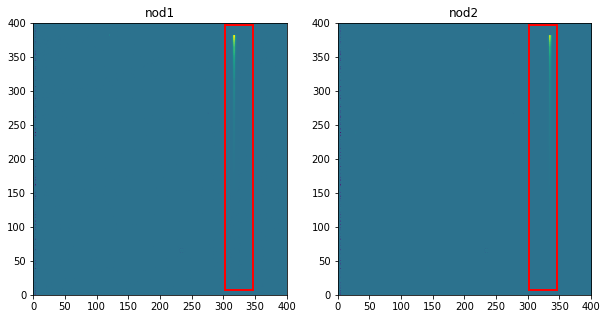

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[10,5])

bbox0 = Rectangle((awcs_out[0].meta.wcs.bounding_box[0][0],awcs_out[0].meta.wcs.bounding_box[1][0]), bbox_w, bbox_ht, angle=0.0, ec='r', lw=2, fc='None')
bbox1 = Rectangle((awcs_out[1].meta.wcs.bounding_box[0][0],awcs_out[1].meta.wcs.bounding_box[1][0]), bbox_w, bbox_ht, angle=0.0, ec='r', lw=2, fc='None')

ax[0].imshow(awcs_out[0].data, origin='lower', interpolation='None', aspect='auto')
ax[0].add_patch(bbox0)
ax[0].set_xlim([0,400])
ax[0].set_ylim([0,400])
ax[0].set_title(nods[0])

ax[1].imshow(awcs_out[1].data, origin='lower', interpolation='None', aspect='auto')
ax[1].add_patch(bbox1)
ax[1].set_xlim([0,400])
ax[1].set_ylim([0,400])
ax[1].set_title(nods[1])

np.shape(awcs_out[0].data)

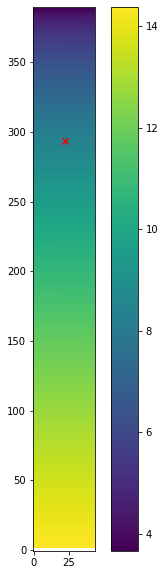

In [10]:
# Plot the wavelength solution based on the wcs information in the model
siaf = Siaf('MIRI')
ap = siaf['MIRIM_SLIT']
refpx_tel = ap.reference_point(to_frame='tel')
refpx_abs = mt.v2v3toxy(refpx_tel[0], refpx_tel[1], filter='F770W')
refpx = (refpx_abs[0] - awcs_out[0].meta.wcs.bounding_box[0][0], refpx_abs[1] - awcs_out[0].meta.wcs.bounding_box[1][0])
#print(refpx)

x,y = grid_from_bounding_box(awcs_out[0].meta.wcs.bounding_box)
ra, dec, lam = awcs_out[0].meta.wcs(x, y)

fig = plt.figure(figsize=[6,10])
imlam=plt.imshow(lam, origin='lower', interpolation='None')
cbar = fig.colorbar(imlam)
plt.scatter(refpx[0], refpx[1], marker='x', color='r')

Load the set of test coordinates from ``miricoord``. Then calculate the wavelength of these coordinates from the assign_wcs output models, and verify that they are close. If all the ``assert`` tests pass, this test is successful and complete.

In [11]:
xt,yt,v2t,v3t,lamt,stype=tv.testdata()

lamtest1 = np.zeros(3)
lamtest2 = np.zeros(3)
v2test1 = np.zeros(3)
v3test1 = np.zeros(3)
lt1 = np.zeros(3)

print('**** TEST SET ****')
print(' x       y     lam_truth  lamtest1  lamtest2  v2truth   v3truth  v2test   v3test')
for i in range (3):
    v2test1[i], v3test1[i], lt1[i] = xytov2v3lam(xt[0][i], yt[0][i], 'slit') 
    ra, dec, lamtest1[i] = awcs_out[0].meta.wcs(xt[0][i], yt[0][i])
    ra, dec, lamtest2[i] = awcs_out[1].meta.wcs(xt[0][i], yt[0][i])
    print('{0}  {1}   {2}    {3:.5f}    {4:.5f}  {5:.5f}   {6:.5f}   {7:.5f}   {8:.5f}'.format(xt[0][i], yt[0][i], lamt[0][i], lamtest1[i], lamtest2[i], v2t[0][i], v3t[0][i], v2test1[i], v3test1[i]))
    
    
    assert_allclose(lamt[0][i], lamtest1[i], atol=0.05)
    assert_allclose(lamt[0][i], lamtest2[i], atol=0.05)
    assert_allclose(v2t[0][i], v2test1[i], atol=0.05)
    assert_allclose(v3t[0][i], v3test1[i], atol=0.05)

**** TEST SET ****
 x       y     lam_truth  lamtest1  lamtest2  v2truth   v3truth  v2test   v3test
325.13  299.7   8.41039    8.41039    8.41039  -415.06900   -400.57590   -415.06905   -400.57592


325.13  29.7   14.05363    14.05363    14.05363  -415.19460   -400.56550   -415.19455   -400.56549
345.13  379.7   5.1474    5.14743    5.14743  -417.23700   -400.39580   -417.23700   -400.39585


<a id="about_ID"></a>
## About this Notebook
**Author:** Sarah Kendrew, ESA MIRI Instrument & Calibration Scientist, MIRI branch
<br>**Updated On:** 12/08/2020

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 